In [138]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from aerobot.io import RESULTS_PATH, ASSET_PATH, FEATURE_TYPES
from aerobot.dataset import dataset_load_all, dataset_load_feature_order
from aerobot.models import GeneralClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticks
from scipy.stats import linregress

# Some specs to make plots look nice. 
TITLE_FONT_SIZE, LABEL_FONT_SIZE = 12, 8
PALETTE = 'Paired'
# Set all matplotlib global parameters.
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size':LABEL_FONT_SIZE})
plt.rc('xtick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('ytick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('axes',  **{'titlesize':TITLE_FONT_SIZE, 'labelsize':LABEL_FONT_SIZE})
# plt.rcParams['image.cmap'] = 'Paired'
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired.colors)


In [139]:
EMB_RESULTS_PATH = os.path.join(RESULTS_PATH, 'earth_microbiome')
BS_RESULTS_PATH = os.path.join(RESULTS_PATH, 'black_sea')

model_class = 'nonlinear'

Black sea data is stored on HPC under `/central/groups/fischergroup/goldford/earth_microbiome/proteins`. The data file has a column for each amino acid trimer (there are over 9000). I think I will need to filter the features to match the features the model was trained on, as several columns are dropped when loading the raw feature data into a `dataset`.

In [141]:
# First step is to train a nonlinear model on the training data. 
! python ../scripts/run.py 'nonlinear' --feature-type 'aa_3mer' --save-model 1 --n-epochs 500 --save-model-path 'aa_3mer_nonlinear_model.joblib'
! python ../scripts/run.py 'logistic' --feature-type 'aa_3mer' --save-model 1 --max-iter 10000 --save-model-path 'aa_3mer_logistic_model.joblib'

Training NonlinearClassifier...:  31%|██▌     | 157/500 [18:40<19:30,  3.41s/it]

## Cleaning Earth Microbiome Project data

In [61]:
# # Load the original run of the logistic classifier
# emb_predictions_original_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'original_run_results_logistic_aa_3mer.csv'), index_col=0)
# emb_predictions_original_df = emb_predictions_original_df.rename(columns={'label':'prediction'})
# emb_predictions_original_df.prediction = emb_predictions_original_df.prediction.str.lower()
# # Load my (Pippa's) run of the logistic classifier on the new data. 
# emb_predictions_logistic_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'run_pretrained_results_logistic_aa_3mer.csv'), index_col=0)
# # Load my (Pippa's) run of the nonlinear classifier on the new data. 
# emb_predictions_nonlinear_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'run_pretrained_results_nonlinear_aa_3mer.csv'), index_col=0)

# print('Predictions from original run:')
# print(emb_predictions_original_df.prediction.value_counts())

# print('\nPredictions from new logistic run:')
# print(emb_predictions_logistic_df.prediction.value_counts())

# print('\nPredictions from new nonlinear run:')
# print(emb_predictions_nonlinear_df.prediction.value_counts())


In [110]:
# Load the Earth microbiome project analysis and metadata.
emb_metadata_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_metadata.tsv'), sep='\t', index_col=0, dtype={'metagenome_id':str})
emb_predictions_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'run_pretrained_results_{model_class}_aa_3mer.csv'), index_col=0)
# emb_predictions_df.index = emb_metadata_df.index # I think this is OK? Indices should match, no scrambling happens during predictions.
print('Number of predictions:', len(emb_predictions_df))
print('Number of metadata entries:', len(emb_metadata_df))
# Combine the predictions and metadata.
emb_predictions_df = pd.concat([emb_metadata_df, emb_predictions_df], axis=1)
print('Number of entries after concatenating DataFrames:', len(emb_predictions_df))

Number of predictions: 52515
Number of metadata entries: 52515
Number of entries after concatenating DataFrames: 52515


In [111]:
# Replace habitat names with more general categories.
habitat_map = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_habitats.csv'), index_col=0).to_dict()['habitat']
emb_predictions_df.habitat = emb_predictions_df.habitat.replace(habitat_map)

In [112]:
# Filter out low-completeness MAGs.
emb_predictions_df = emb_predictions_df[emb_predictions_df.completeness > 50]
print(len(emb_predictions_df), 'genomes with >50 percent completeness.')

# Filter out entries from samples with fewer than ten MAGs
counts = emb_predictions_df.groupby('metagenome_id').apply(len)
ids_to_keep = counts.index[counts > 10]
emb_predictions_df = emb_predictions_df[emb_predictions_df.metagenome_id.isin(ids_to_keep)]
print(len(emb_predictions_df), 'genomes from samples with more than ten genomes.')

# Filter our habitats with fewer than ten samples.
counts = emb_predictions_df.groupby('habitat').apply(len)
habitats_to_keep = counts.index[counts > 10]
emb_predictions_df = emb_predictions_df[emb_predictions_df.habitat.isin(habitats_to_keep)]
print(len(emb_predictions_df), 'genomes from habitats with more than ten samples')

52425 genomes with >50 percent completeness.
31279 genomes from samples with more than ten genomes.
31279 genomes from habitats with more than ten samples


In [115]:
# Calculate the aerobe-anaerobe-facultative fractions for each sample.
classes = set(emb_predictions_df.prediction.values) # Get the metabolic categories.

rows = []
# Iterate through the groups of habitats. Get the fraction of each organism time in the habitat.
for habitat, df in emb_predictions_df.groupby('habitat'):
    counts = df.prediction.value_counts()
    row = counts.astype(float) / counts.sum()
    row = row.to_dict()
    row = {f'{k}_fraction':v for k, v in row.items()}
    row.update(counts.astype(float).to_dict())
    row['total'] = counts.sum()
    row['habitat'] = habitat
    rows.append(row)

emb_results_df = pd.DataFrame(rows)
emb_results_df = emb_results_df.fillna(0)
# NOTE: Should we group facultative and aerobe?
emb_results_df['aerobe_anaerobe_ratio'] = emb_results_df['aerobe_fraction'] / emb_results_df['anaerobe_fraction']
emb_results_df.to_csv(os.path.join(EMB_RESULTS_PATH, 'emb_results.csv'))


## Cleaning Black Sea data

In [97]:
# # Load the original run of the logistic classifier
# bs_predictions_original_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'original_run_results_logistic_aa_3mer.csv'), index_col=0)
# bs_predictions_original_df = bs_predictions_original_df.rename(columns={'label':'prediction'})
# bs_predictions_original_df.prediction = bs_predictions_original_df.prediction.str.lower()
# # Load my (Pippa's) run of the logistic classifier on the new data. 
# bs_predictions_logistic_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'run_pretrained_results_logistic_aa_3mer.csv'), index_col=0)
# # Load my (Pippa's) run of the nonlinear classifier on the new data. 
# bs_predictions_nonlinear_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'run_pretrained_results_nonlinear_aa_3mer.csv'), index_col=0)

# print('Predictions from original run:')
# print(bs_predictions_original_df.prediction.value_counts())

# print('\nPredictions from new logistic run:')
# print(bs_predictions_logistic_df.prediction.value_counts())

# print('\nPredictions from new nonlinear run:')
# print(bs_predictions_nonlinear_df.prediction.value_counts())

In [116]:
# Load the black sea metadata
bs_metadata_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, 'bs_metadata.csv'), index_col=0)
bs_metadata_df['depth_m'] = bs_metadata_df['Depth'].str.strip('m').astype(float)

# Chemical measurements are from Sollai et al. 2019 Geobiology. In their Figure 1, it's clear these are in uM units 
# despite what it says in our metadata file, which was downloaded from the SRA at this link:
# https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=3&WebEnv=MCID_6582027b68a595196d9af8e7&o=acc_s%3Aa
# uM units make sense as the Henry's law equilibrium of O2 in seawater is ~200 uM.
bs_metadata_df['o2_uM'] = bs_metadata_df['diss_oxygen'].str.strip('mmol / kg').astype(float)
bs_metadata_df['h2s_uM'] = bs_metadata_df['hydrogen_sulfide'].str.strip('mM').astype(float)
bs_metadata_df = bs_metadata_df.sort_values('depth_m')

In [117]:
# Load the black sea MAG inference results
bs_predictions_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'run_pretrained_results_{model_class}_aa_3mer.csv'), index_col=0)
bs_mag_fractions_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, 'bs_mag_fraction.csv'), index_col=0).drop('*')

bs_mag_fractions_df['prediction'] = bs_predictions_df.loc[bs_mag_fractions_df.index]
bs_results_df = bs_mag_fractions_df.groupby('prediction').sum().T * 100
bs_results_df = bs_results_df

bs_results_df['depth_m'] = bs_metadata_df.loc[bs_results_df.index].depth_m
bs_results_df['o2_uM'] = bs_metadata_df.loc[bs_results_df.index].o2_uM
bs_results_df['h2s_uM'] = bs_metadata_df.loc[bs_results_df.index].h2s_uM
bs_results_df = bs_results_df.sort_values('depth_m')
bs_results_df.to_csv(os.path.join(BS_RESULTS_PATH, 'bs_results.csv'))


## Figure 2

In [130]:
def plot_figure_2a(emb_results_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

        # Create a new axis in the grid.
        ax = fig.add_subplot(grid)
        # Convert fraction columns to percentages.
        for col in emb_results_df.columns:
                if 'fraction' in col:
                        emb_results_df[col.replace('fraction', 'percent')] = emb_results_df[col] * 100

        cols = ['habitat', 'anaerobe_percent', 'aerobe_percent', 'facultative_percent']
        emb_results_df = emb_results_df[(emb_results_df.total > 240) & ~emb_results_df.habitat.str.match('Host-associated')]

        emb_results_df = emb_results_df[cols].set_index('habitat').sort_values('anaerobe_percent', ascending=False)

        emb_results_df.plot(kind='bar', stacked=True, ax=ax, legend=False, edgecolor='k', linewidth=0.5)
        ax.legend(['Anaerobe', 'Aerobe', 'Facultative'], loc=3)
        # ax.legend(mean_fractions_df.prediction.unique(), loc=3)
        ax.set_ylabel('percent of MAGs in samples')
        ax.set_xlabel('')
        ax.set_xticks(np.arange(len(emb_results_df.index)), labels=emb_results_df.index.values, rotation=45, ha='right')
        ax.set_ylim(0, 100.1)
        ax.yaxis.set_major_formatter(ticks.PercentFormatter())

In [134]:
def plot_figure_2b(bs_results_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Define a new sub-grid from the original grid. 
    sub_grid = GridSpecFromSubplotSpec(1, 2, wspace=0.3, hspace=0.2, subplot_spec=grid)
    ax_1 = fig.add_subplot(sub_grid[0, 0])
    ax_2 = fig.add_subplot(sub_grid[0, 1])

    ax_1.invert_yaxis() #, ax[1].invert_yaxis() # Invert the axis, so surface is at the top. 
    ax_2.invert_yaxis() #, ax[1].invert_yaxis() # Invert the axis, so surface is at the top. 
    ax_2.set_yscale('log'), ax_2.set_yscale('log') # Convert depth axis to logscale.
    ax_2.set_yticks([])
    ax_1.set_ylabel('depth (m)')

    ax_1.set_xscale('log') # Convert x-axis to logscale.
    ax_1.set_xlabel('concentration ($\mu$M)')
    ax_1.plot(bs_results_df.h2s_uM, bs_results_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:blue', markeredgecolor='w', label='H$_2$S')
    ax_1.plot(bs_results_df.o2_uM, bs_results_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:green', markeredgecolor='w', label='O$_2$')
    # ax_1.legend(['h2s', 'o2'])

    ax_2.set_xlabel('relative abundance')
    ax_2.plot(bs_results_df['aerobe'], bs_results_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:red', markeredgecolor='w', label='aerobe')
    ax_2.plot(bs_results_df['anaerobe'], bs_results_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:orange', markeredgecolor='w', label='anaerobe')
    # ax_2.legend(['aerobe', 'anaerobe'])

In [135]:
def plot_figure_2c(bs_results_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Create an axis in the specified grid space.
    ax = fig.add_subplot(grid)

    # Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
    o2_h2s_ratio = bs_results_df.o2_uM / bs_results_df.h2s_uM
    aerobe_anaerobe_ratio = bs_results_df.aerobe / bs_results_df.anaerobe

    # Perform linear regression on the log-transformed data. 
    log_o2_h2s_ratio = np.log10(o2_h2s_ratio)
    log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)

    # Do linear regression on the log ratios.
    reg = linregress(log_aerobe_anaerobe_ratio, log_o2_h2s_ratio)
    x_vals = np.logspace(log_aerobe_anaerobe_ratio.min(), log_aerobe_anaerobe_ratio.max(), 100)
    y_vals = reg.intercept + reg.slope * np.log10(x_vals)

    ax.loglog(aerobe_anaerobe_ratio.values, o2_h2s_ratio.values, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')
    ax.plot(x_vals, 10**y_vals, color='k', ls='--', lw=0.75, zorder=-1)

    # Bootstrap a confidence interval plot manually because seaborns regplot doesn't handle log scale...
    for _ in range(1000):
        slope = np.random.normal(reg.slope, reg.stderr)
        intercept = np.random.normal(reg.intercept, reg.intercept_stderr)
        y_vals = intercept + slope * np.log10(x_vals)
        ax.plot(x_vals, 10**y_vals, color='lightblue', ls='-', lw=0.5, zorder=-10)

    ax.set_xlabel('inferred aerobe/anaerobe ratio')
    ax.set_ylabel('[O$_2$]/[H$_2$S] ratio')
    ax.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg.rvalue, reg.pvalue), fontsize=7, transform=ax.transAxes, ha='right', va='bottom')
    plt.show()

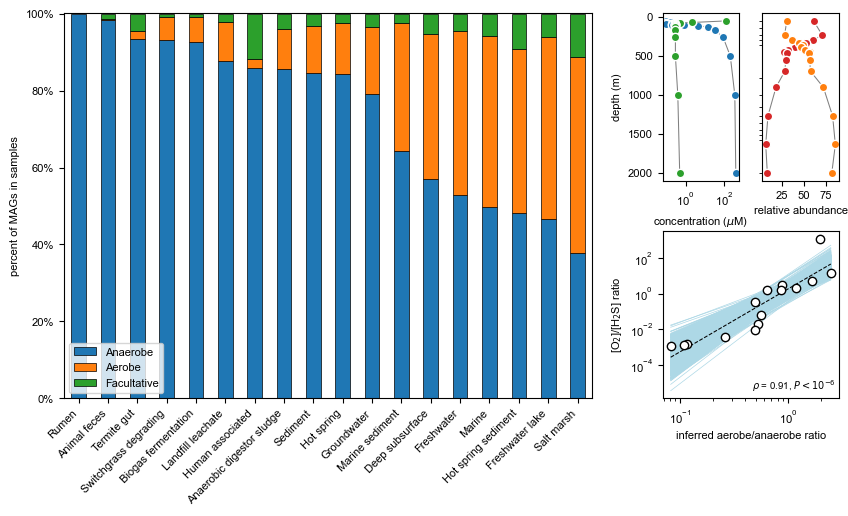

<Figure size 640x480 with 0 Axes>

In [136]:
fig = plt.figure(figsize=(10, 5))
grid = GridSpec(2, 2, width_ratios=(3, 1), wspace=0.2, hspace=0.3)

plot_figure_2a(emb_results_df, grid=grid[0:, 0], fig=fig)
plot_figure_2b(bs_results_df, grid=grid[0, 1], fig=fig)
plot_figure_2c(bs_results_df, grid=grid[1, 1:], fig=fig)

plt.tight_layout()
plt.show()
